In [3]:
import sys,os
rootpath = os.path.join(os.getcwd(),'..')
sys.path.append(rootpath)

In [4]:
from models import SimpleCNNv2Lightning
import pandas as pd
from evaluation import cmc_evaluation_df
import numpy as np
import torch
from torch.utils.data import DataLoader
from evaluation import filename2image_set
import pytorch_lightning as L
from tqdm import tqdm
import tensorflow as tf


In [ ]:
model = SimpleCNNv2Lightning.load_from_checkpoint("logs\lightning_logs\\version_65\checkpoints\epoch=419-step=70980.ckpt")
model_long_term = SimpleCNNv2Lightning.load_from_checkpoint("logs/lightning_logs/version_98/checkpoints/epoch=194-step=2925.ckpt")

In [ ]:
#test_different_day_same_hour = pd.read_csv("data/test_different_day_same_hour.csv")
#test_different_day = pd.read_csv("data/test_different_day.csv")
test_same_hour = pd.read_csv("data/test_same_hour.csv")


In [ ]:
df = test_same_hour.copy()
tsh_df = pd.read_csv("data/test_same_hour.csv")
tsh_df = tsh_df[tsh_df.image_id < 10 + 2]
tsh_df.head()

,Unnamed: 0.1,Unnamed: 0,iteration_id,gallery_id,image_id,filename
0,0,0,0,0,0,uncensored_dataset/images/5_02_R_190803090000/...
1,1,1,0,0,1,uncensored_dataset/images/6_02_R_190803100000/...
2,2,2,0,0,2,uncensored_dataset/images/187_02_R_19080214212...
3,3,3,0,0,3,uncensored_dataset/images/182_02_R_19080210000...
4,4,4,0,0,4,uncensored_dataset/images/13_02_R_190803170000...


In [ ]:

queries_and_galleries = tsh_df.filename.values
dataset = filename2image_set(queries_and_galleries, rescale_factor=4, image_size=(224, 224),num_workers=6)
batch_size = 32
dataloader= DataLoader(dataset, batch_size=batch_size,prefetch_factor=5,num_workers=6)

model_long_term.eval()   
trainer = L.Trainer()
predictions = []

'''
with torch.no_grad():
    predictions = trainer.predict(model=model, dataloaders=dataloader)
'''

for batch in tqdm(dataloader):
    with torch.no_grad():
        predictions.append(model_long_term(batch))
    
print(len(predictions))   
        

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


456000


100%|██████████| 14250/14250 [08:03<00:00, 29.49it/s]

14250


In [ ]:
#preds = np.ndarray((len(predictions),32,128))
preds=[]
#print(predictions[0].shape)
for i in tqdm(range(0, len(predictions))):
    for j in range(0,predictions[i].cpu().numpy().shape[0]):
        preds.append(predictions[i][j].cpu().numpy())
    #print(i)
    #preds[i] = predictions[i].cpu()
preds_np = np.array(preds)


#preds = preds_np.reshape(-1, 128)



100%|██████████| 14250/14250 [00:31<00:00, 450.34it/s]


In [ ]:
print(len(preds))
preds_np = np.array(preds)
preds_np.shape
preds = preds_np

456000


In [ ]:

query_gallery_size = tsh_df.image_id.max() + 1
n_distractors = query_gallery_size - 2

galleries_per_iteraration = len(df.gallery_id.unique())
iterations  = df.iteration_id.max() + 1

total_galleries =  galleries_per_iteraration * iterations

queries_emb = preds[::query_gallery_size]
pred_idx = np.arange(0, len(preds))

galleries_emb = preds[np.mod(pred_idx, query_gallery_size) != 0]

queries_emb = queries_emb.reshape(total_galleries, 1, -1)
galleries_emb = galleries_emb.reshape(total_galleries, n_distractors + 1, -1 )

# Calculuate distance
cos_dist = tf.matmul(queries_emb, galleries_emb, transpose_b=True).numpy()
euclid_dist = -(cos_dist - 1)

# Calculate Rank
r = np.argmin(np.argsort(euclid_dist), axis=2)
r = np.squeeze(r)

ranks = np.zeros(n_distractors)
for i in range(n_distractors):
    ranks[i] = np.mean(r < (i + 1))


In [ ]:
print(ranks)

[0.24328947 0.35952632 0.44678947 0.52639474 0.60471053 0.67923684
 0.75481579 0.82557895 0.89289474 0.95794737]


In [7]:
from models import SimpleCNNv2Lightning
import pandas as pd

from evaluation import cmc_evaluation_df

best_model = SimpleCNNv2Lightning.load_from_checkpoint("D:\ss24_seminarstatistic\logs\lightning_logs\\version_114\checkpoints\epoch=137-step=2070.ckpt")
tsh_df = pd.read_csv("D:\ss24_seminarstatistic\data/test_same_hour.csv")
n_distractors=10
tsh_df = tsh_df[tsh_df.image_id < n_distractors + 2]
tsh_ranks = cmc_evaluation_df(best_model, tsh_df)
print(tsh_ranks)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
  0%|          | 0/456000 [00:15<?, ?it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "d:\anaconda3\envs\pytorch-gpu-python-3-10\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "d:\anaconda3\envs\pytorch-gpu-python-3-10\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "d:\anaconda3\envs\pytorch-gpu-python-3-10\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "d:\ss24_seminarstatistic\notebooks\..\dataset.py", line 196, in __getitem__
    image = Image.open(img_path).convert('RGB')
  File "d:\anaconda3\envs\pytorch-gpu-python-3-10\lib\site-packages\PIL\Image.py", line 3277, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'D:\\ss24_seminarstatistic\\notebooks\\data\\uncensored_dataset\\images\\5_02_R_190803090000\\000006702.jpg'


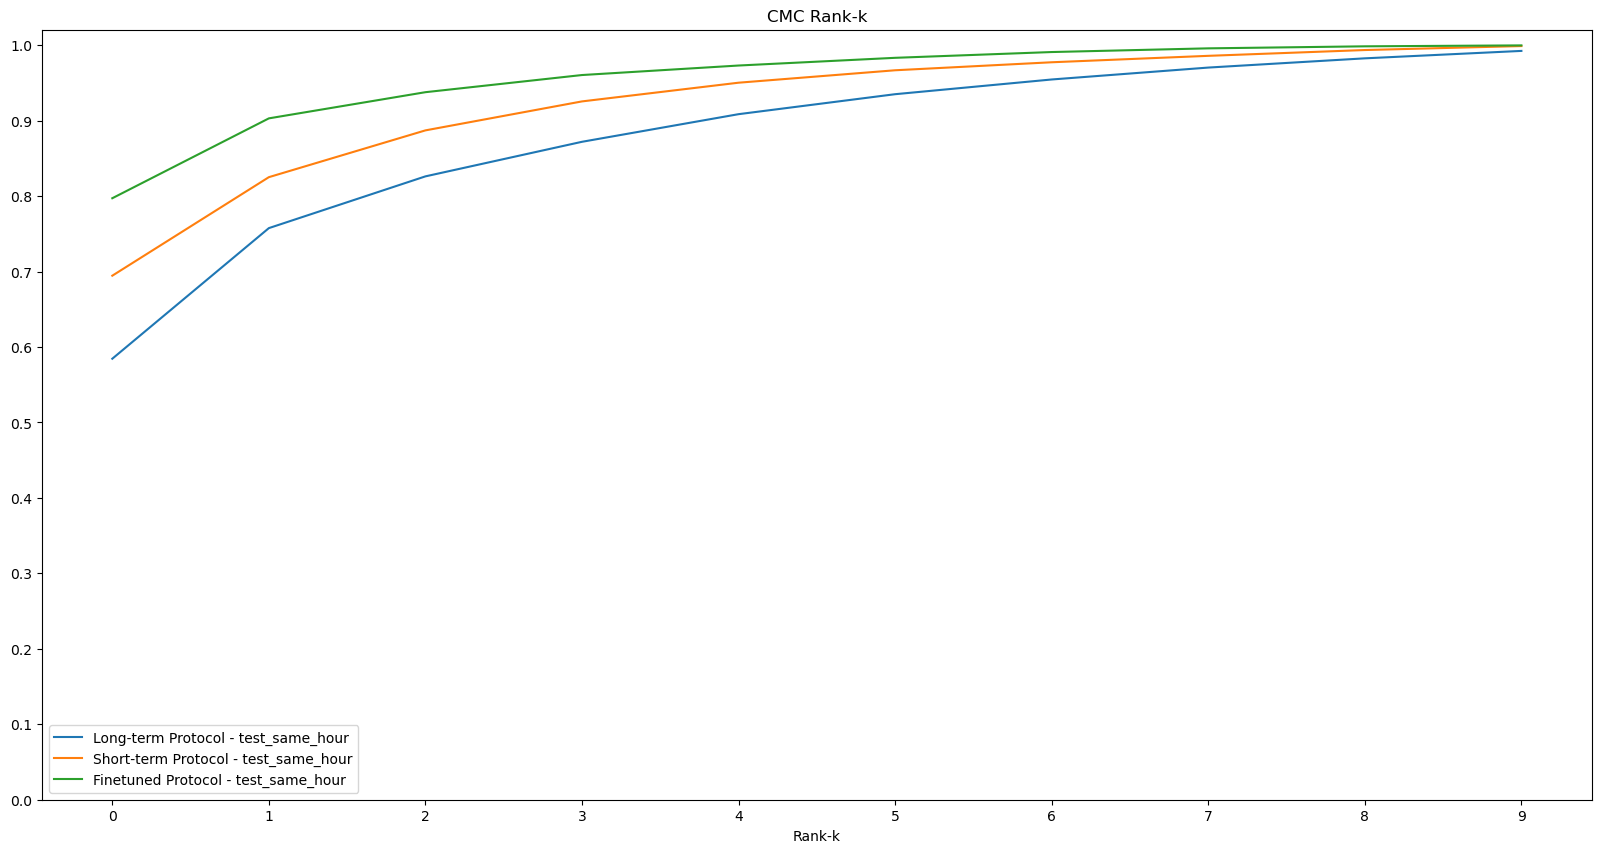

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df1 = pd.read_csv("D:/ss24_seminarstatistic/results/results_longterm.csv")
df2 = pd.read_csv("D:/ss24_seminarstatistic/results/results_short_term.csv")
df3 = pd.read_csv("D:/ss24_seminarstatistic/results/results_finetuned.csv")
df1.drop("Unnamed: 0", axis=1,inplace=True)
df2.drop("Unnamed: 0", axis=1,inplace=True)
df3.drop("Unnamed: 0", axis=1,inplace=True)
plt.figure(figsize=(20,10))
column = "test_same_hour"
plt.plot(df1.index, df1[column], label=f'Long-term Protocol - {column}')
plt.plot(df2.index, df2[column], label=f'Short-term Protocol - {column}')
plt.plot(df3.index, df3[column], label=f'Finetuned Protocol - {column}')    

plt.xlabel("Rank-k")
plt.xticks(range(0,10))
plt.yticks(np.linspace(0,1.0,11))
plt.ylabel("")
plt.title("CMC Rank-k")
plt.legend(loc="best")
plt.show()


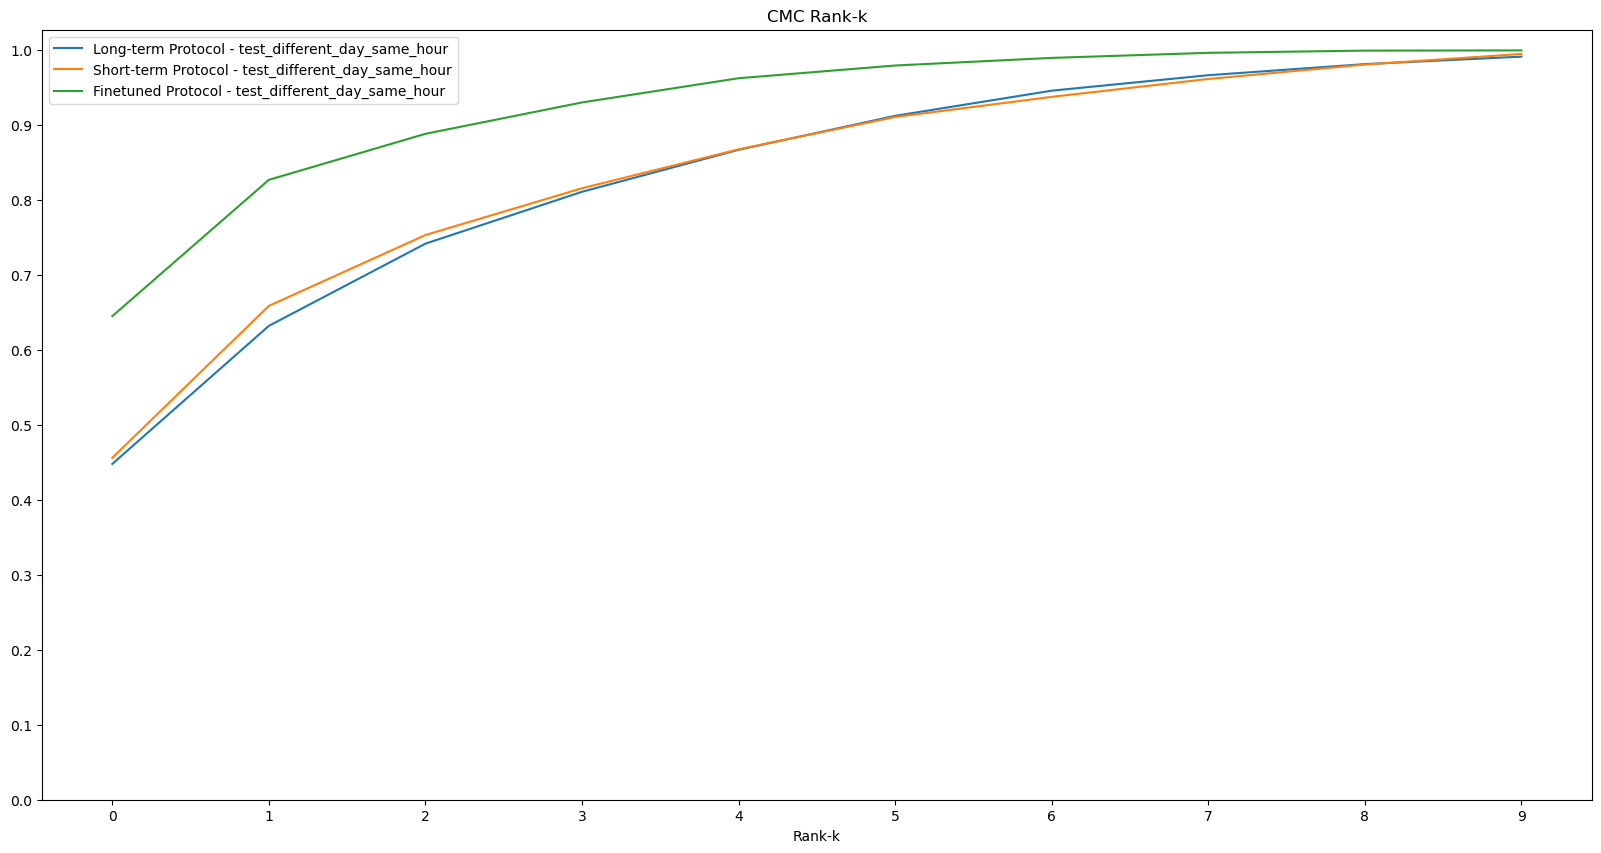

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df1 = pd.read_csv("D:/ss24_seminarstatistic/results/results_longterm.csv")
df2 = pd.read_csv("D:/ss24_seminarstatistic/results/results_short_term.csv")
df3 = pd.read_csv("D:/ss24_seminarstatistic/results/results_finetuned.csv")
df1.drop("Unnamed: 0", axis=1,inplace=True)
df2.drop("Unnamed: 0", axis=1,inplace=True)
df3.drop("Unnamed: 0", axis=1,inplace=True)
plt.figure(figsize=(20,10))
column = "test_different_day_same_hour"
plt.plot(df1.index, df1[column], label=f'Long-term Protocol - {column}')
plt.plot(df2.index, df2[column], label=f'Short-term Protocol - {column}')
plt.plot(df3.index, df3[column], label=f'Finetuned Protocol - {column}')    

plt.xlabel("Rank-k")
plt.xticks(range(0,10))
plt.yticks(np.linspace(0,1.0,11))
plt.ylabel("")
plt.title("CMC Rank-k")
plt.legend(loc="best")
plt.show()


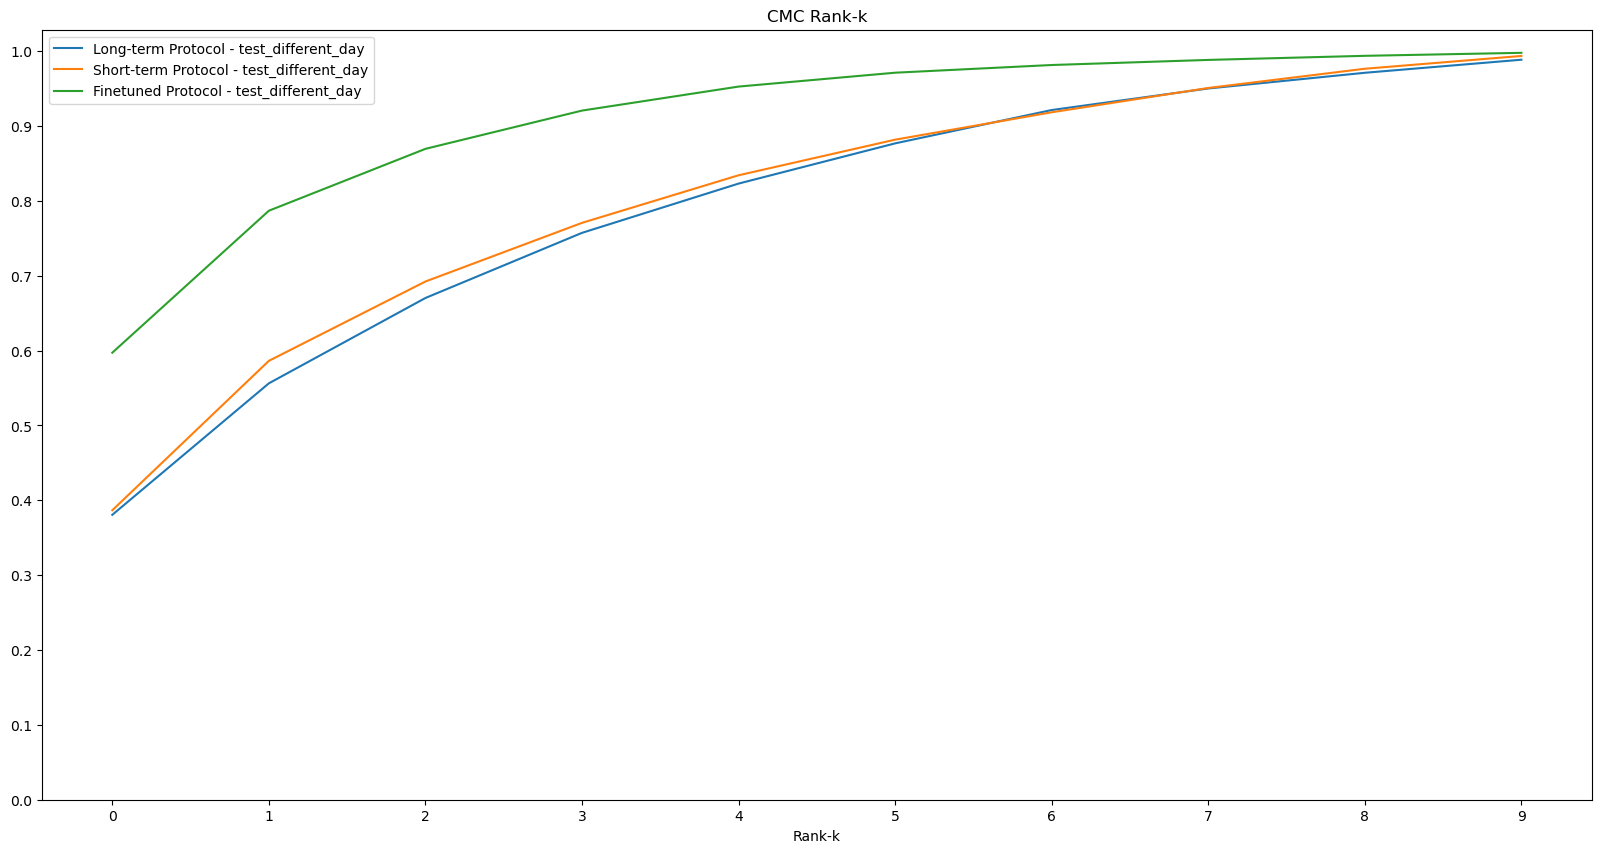

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df1 = pd.read_csv("D:/ss24_seminarstatistic/results/results_longterm.csv")
df2 = pd.read_csv("D:/ss24_seminarstatistic/results/results_short_term.csv")
df3 = pd.read_csv("D:/ss24_seminarstatistic/results/results_finetuned.csv")
df1.drop("Unnamed: 0", axis=1,inplace=True)
df2.drop("Unnamed: 0", axis=1,inplace=True)
df3.drop("Unnamed: 0", axis=1,inplace=True)
plt.figure(figsize=(20,10))
column = "test_different_day"
plt.plot(df1.index, df1[column], label=f'Long-term Protocol - {column}')
plt.plot(df2.index, df2[column], label=f'Short-term Protocol - {column}')
plt.plot(df3.index, df3[column], label=f'Finetuned Protocol - {column}')    

plt.xlabel("Rank-k")
plt.xticks(range(0,10))
plt.yticks(np.linspace(0,1.0,11))
plt.ylabel("")
plt.title("CMC Rank-k")
plt.legend(loc="best")
plt.show()
